# Installation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
GOOGLE_PATH = "/content/drive/MyDrive/ColabNotebooks/final"
sys.path.append(GOOGLE_PATH)

In [4]:
!pip install datasets
!pip install map_boxes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00


In [5]:
import random
import torch
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm, trange
import datasets
import pandas as pd
from IPython.display import display, clear_output
from map_boxes import mean_average_precision_for_boxes
from datasets import Dataset, DatasetDict
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights, FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [6]:
CUSTOM_FACE_PATH = f"{GOOGLE_PATH}/data/CUSTOM_FACE"

In [7]:
dataset = datasets.load_from_disk(str(CUSTOM_FACE_PATH))

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'faces'],
        num_rows: 6402
    })
    validation: Dataset({
        features: ['image', 'faces'],
        num_rows: 1527
    })
})

# Pretrained NN


In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [32]:
class FaceDetectionDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
        # if len(self.dataset) > 6000:
          # return len(self.dataset) // 10
        # else:
        #   return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]['image'].convert('RGB'))
        bboxes = torch.FloatTensor(self.dataset[idx]['faces']['bbox'])
        bboxes = torchvision.ops.box_convert(
            bboxes, in_fmt='xywh', out_fmt='xyxy',
        )
        class_labels = [1] * len(bboxes)

        if self.transform:
            transformed_data = self.transform(
                image=image, bboxes=bboxes, class_labels=class_labels
            )
            image = transformed_data["image"]
            bboxes = transformed_data["bboxes"]
            class_labels = transformed_data["class_labels"]

        return (
            torch.from_numpy(image).permute(2, 0, 1),
            {
                'image_id': idx,
                'boxes': torch.FloatTensor(bboxes),
                'labels': torch.LongTensor(class_labels),
            }
        )

In [41]:
train_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', label_fields=['class_labels']
    )
)

val_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', label_fields=['class_labels']
    )
)

In [33]:
def collate_fn(batch):
    return tuple(zip(*batch))

BATCH_SIZE = 30

train_dataset = FaceDetectionDataset(
    dataset=dataset['train'], transform=train_transform,
)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, collate_fn=collate_fn,
)

val_dataset = FaceDetectionDataset(
    dataset=dataset['validation'], transform=val_transform,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn,
)

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_image_with_boxes(image, boxes):
    image = image.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()


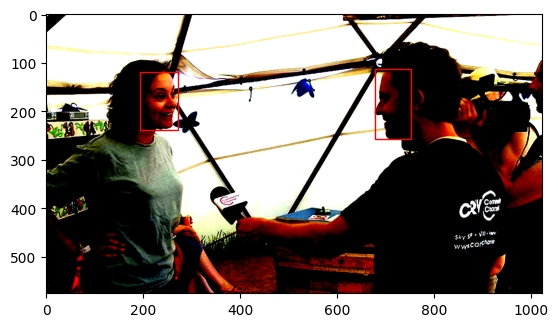

In [23]:
idx = random.randint(0, len(train_dataset))
img = train_dataset[idx][0]
boxes = train_dataset[idx][1]['boxes']
draw_image_with_boxes(img, boxes)

In [24]:
def get_metric_format(images, targets, outputs):
    target_list, pred_list = [], []
    for image, target, output in zip(images, targets, outputs):
        c, h, w = image.shape

        image_id = target['image_id']
        labels = target['labels']
        boxes = target['boxes']
        for label, box in zip(labels, boxes):
            x_min, y_min, x_max, y_max = box
            x_min, x_max = x_min / w, x_max / w
            y_min, y_max = y_min / h, y_max / h
            target_list.append([
                image_id, label.item(),
                x_min.item(), x_max.item(), y_min.item(), y_max.item(),
            ])

        labels = output['labels']
        scores = output['scores']
        boxes = output['boxes']
        for label, score, box in zip(labels, scores, boxes):
            x_min, y_min, x_max, y_max = box
            x_min, x_max = x_min / w, x_max / w
            y_min, y_max = y_min / h, y_max / h
            pred_list.append([
                image_id, label.item(), score.item(),
                x_min.item(), x_max.item(), y_min.item(), y_max.item(),
            ])

    return target_list, pred_list

def average_precision(target_list, pred_list, thrs):
    ap_per_thr = []
    for thr in thrs:
        mean_ap, _ = mean_average_precision_for_boxes(
            target_list, pred_list, iou_threshold=thr,
            verbose=False,
        )
        ap_per_thr.append(mean_ap)
    return sum(ap_per_thr) / len(ap_per_thr)

def train_epoch(loader, model, optimizer):
    model = model.to(DEVICE)
    model.train()
    avg_loss = 0.0
    optimizer.zero_grad()
    for images, targets in tqdm(loader):
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss += losses.item()
    avg_loss /= len(loader)
    return avg_loss

def valid_epoch(loader, model, thrs=np.linspace(0.5, 0.95, 10)):
    model = model.to(DEVICE)
    model.eval()
    targets_metric, preds_metric = [], []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            outputs = model(images)
            target_list, pred_list = get_metric_format(images, targets, outputs)
            targets_metric.extend(target_list)
            preds_metric.extend(pred_list)
    return average_precision(targets_metric, preds_metric, thrs)

In [35]:
num_classes = 2
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

In [36]:
TORCH_WEIGHTS = f'{GOOGLE_PATH}/best_model_.pth'
model.load_state_dict(torch.load(TORCH_WEIGHTS, map_location=DEVICE))

<All keys matched successfully>

100%|██████████| 51/51 [01:13<00:00,  1.43s/it]


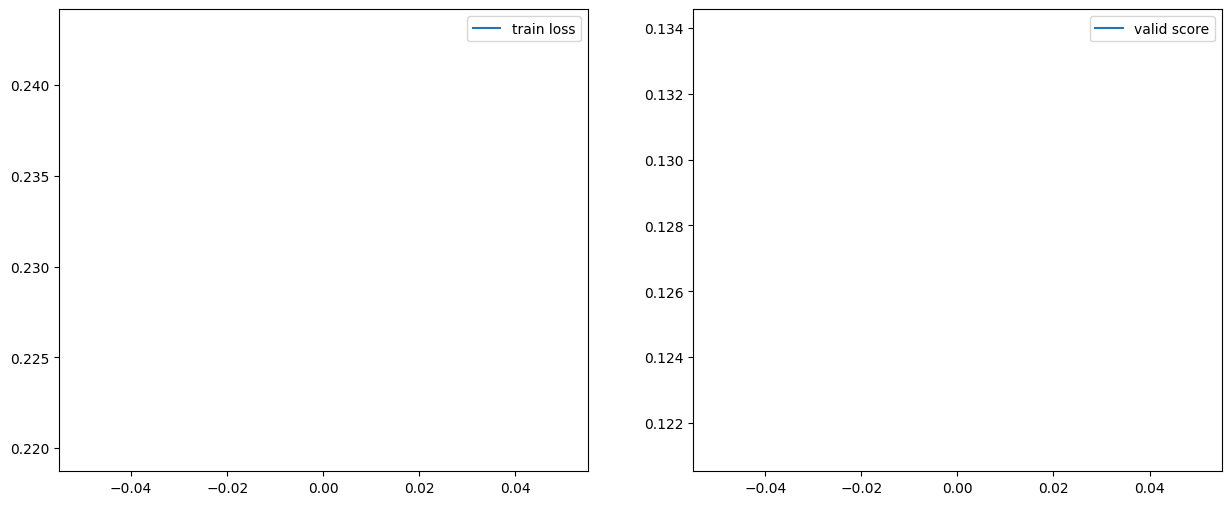

Epoch: 0, train_loss:  0.2314, valid_score:  0.1276, best_score:  0.1276



100%|██████████| 51/51 [01:12<00:00,  1.42s/it]


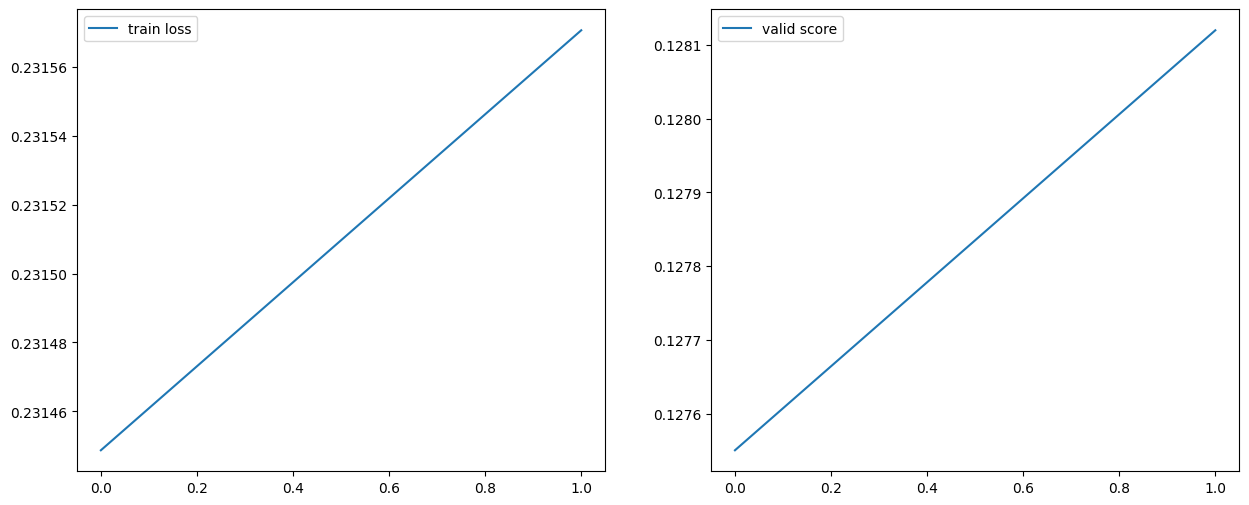

Epoch: 1, train_loss:  0.2316, valid_score:  0.1281, best_score:  0.1281



 21%|██        | 44/214 [01:06<04:15,  1.50s/it]


KeyboardInterrupt: 

In [37]:
best_score = 0.1261
learning_rate = 1e-3

metrics = {
    'train_loss': [],
    'val_score': [],
}

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
for epoch in range(30):
    train_loss = train_epoch(train_loader, model, optimizer)
    val_score = valid_epoch(val_loader, model)

    if val_score > best_score:
        torch.save(model.state_dict(), f'{GOOGLE_PATH}/best_model.pth')
        best_score = val_score

    metrics["train_loss"].append(train_loss)
    metrics["val_score"].append(val_score)

    # clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=[15, 6])

    axs[0].plot(metrics["train_loss"], label='train loss')
    axs[1].plot(metrics["val_score"], label='valid score')

    for i in range(2):
        axs[i].legend()

    plt.show()
    print(
        f'Epoch: {epoch}, train_loss: {train_loss: .4f}, '
        f'valid_score: {val_score: .4f}, best_score: {best_score: .4f}\n'
    )